In [1]:
from sparse_coding_torch.video_loader import YoloClipLoader
from sparse_coding_torch.utils import plot_video
from sparse_coding_torch.utils import plot_filters
from sparse_coding_torch.video_loader import VideoGrayScaler
from IPython.display import HTML
import torchvision
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt

from sparse_coding_torch.conv_sparse_model import ConvSparseLayer

In [2]:
# Get the devices available and set the batch size
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    batch_size = 1
else:
    batch_size = 4*128
    # batch_size=128
    # batch_size = 3

In [3]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     # torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
     torchvision.transforms.Grayscale(),
     torchvision.transforms.Normalize((0.4808,), (0.2392,))
    ])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [5]:
#x = torch.stack([trainset[i][0] for i in range(len(trainset))])

In [6]:
#x.std()

In [13]:
sparse_layer = ConvSparseLayer(in_channels=1,
                               out_channels=16,
                               kernel_size=(1, 15, 15),
                               stride=1,
                               padding=(0, 7, 7),
                               convo_dim=3,
                               rectifier=True,
                               leaky=False,
                               lam=0.05,
                               max_activation_iter=1000,
                               activation_lr=1e-2)
model = sparse_layer
model = torch.nn.DataParallel(model, device_ids=[1, 0, 2, 3])
model.to(device)

#optimizer = torch.optim.Adam(sparse_layer.parameters(),
#                             lr=5.0e-04, amsgrad=True)
optimizer = torch.optim.SGD(sparse_layer.parameters(),
#                            momentum=0.9,
                            lr=5.0e-01)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-4, steps_per_epoch=len(data_loader), epochs=3)

In [15]:
# sparse_layer.max_activation_iter=200

In [14]:
best = float('inf')
loss_log = []

In [17]:
for epoch in tqdm(range(3)):
    act_sum = None
    epoch_loss = 0
    act_num = 0
    act_denom = 0
    # for local_batch in train_loader:
    for local_batch, labels in data_loader:
        local_batch = local_batch.to(device)
        local_batch = local_batch.unsqueeze(1)

        # activations, inner_loss = model(local_batch)
        
        activations = model(local_batch)
        act_num += len(activations[activations>0])
        act_denom += len(activations.flatten())

        # print("Percent Activation: {}".format(len(activations[activations>0])/len(activations.flatten())))

        loss = sparse_layer.loss(local_batch, activations)
        epoch_loss += loss.item() * local_batch.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()
        sparse_layer.normalize_weights()
        # break

    # plt.plot(inner_loss)
    # scheduler.step()
    epoch_loss /= len(data_loader.sampler)
    loss_log.append(epoch_loss)
    print("Epoch Loss: {}; Percent active: {}".format(epoch_loss, act_num / act_denom))

 33%|███▎      | 1/3 [03:14<06:28, 194.30s/it]

Epoch Loss: 10.60625310333252; Percent active: 0.08854718505859376


 67%|██████▋   | 2/3 [06:26<03:13, 193.13s/it]

Epoch Loss: 10.034706758728028; Percent active: 0.08776911010742187


100%|██████████| 3/3 [09:39<00:00, 193.25s/it]

Epoch Loss: 10.006295091552735; Percent active: 0.08787585083007812


In [16]:
12.75

12.75

In [10]:
size = sparse_layer.max_activation_iter
plt.plot(inner_loss[:size])
print(inner_loss[size])
plt.plot(inner_loss[-size:])
print(inner_loss[-1])

NameError: name 'inner_loss' is not defined

In [11]:
plt.plot(inner_loss[size-40:size])
plt.plot(inner_loss[-40:])

NameError: name 'inner_loss' is not defined

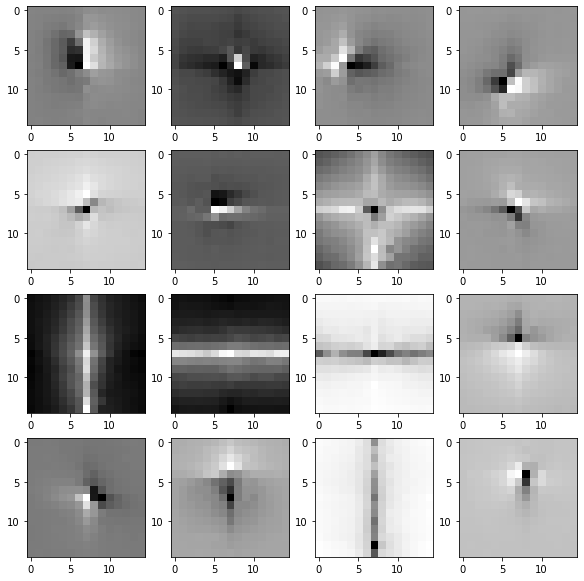

In [18]:
plot_filters(sparse_layer.filters.cpu().detach())

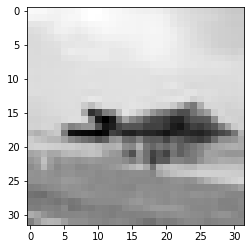

In [138]:
from matplotlib import cm
v = trainset[600][0].squeeze()
plt.imshow(v, cmap=cm.Greys_r)

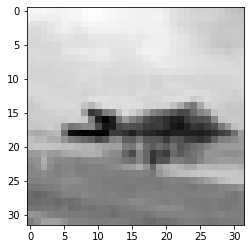

In [139]:
act = model(v.unsqueeze(0).unsqueeze(0).unsqueeze(0).to('cuda:1'))
recon = sparse_layer.reconstructions(act).squeeze().cpu().detach().numpy()
plt.clf()
plt.imshow(recon, cmap=cm.Greys_r)

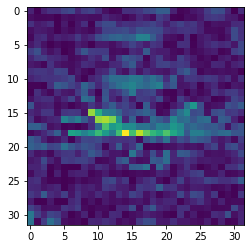

In [140]:
plt.imshow(abs(v - recon))

(array([462., 158.,  86.,  74.,  34.,  32.,  26.,  15.,  13.,  14.,   9.,
          8.,  10.,   8.,   8.,   8.,   4.,   5.,   1.,   1.,   3.,   3.,
          0.,   2.,   0.,   1.,   3.,   2.,   2.,   1.,   3.,   2.,   2.,
          4.,   0.,   0.,   3.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([9.82950610e-10, 2.05533546e-04, 4.11066110e-04, 6.16598673e-04,
        8.22131236e-04, 1.02766380e-03, 1.23319636e-03, 1.43872893e-03,
        1.64426149e-03, 1.84979405e-03, 2.05532662e-03, 2.26085918e-03,
        2.46639174e-03, 2.67192431e-03, 2.87745687e-03, 3.08298943e-03,
        3.28852200e-03, 3.4940

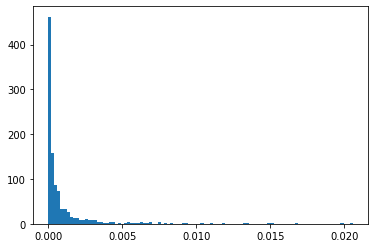

In [99]:
plt.hist(list(e.item() for e in torch.pow((v - recon), 2).flatten()), bins=100)

In [100]:
torch.max(torch.pow(v-recon,2))

tensor(0.0206)